### A/B testing

In [214]:
##Ideal steps
##1. Design the experiment
##2. Data preparation
##3. Visualizingn the results
##4. HP testing & conclusions.

##In this example: 2 versions of webpage (old vs new). We want to increase conversion rate.


##Ho : p = p_0 versus H1 : p!= p_0.
## p_value < alpha, reject Ho. Alpha = 0.05. Confidence 1-alpha
## Power = 1-beta = probability of detecting a differential effects in the two groups when
## there is
## Effect size = the minimum differential effects that we do expect to see in the two groups.

##Control (C): we have shown them the old version; Treatment (T): we have shown them the new
##version. 0 if they did not convert; 1 if they converted.

In [215]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

In [216]:
# Link to Python documentation for statistical modelling.
# https://www.statsmodels.org/stable/user-guide.html#statistics-and-tools

In [217]:
# Power study
def size_of_each_group(p_ex_ante, p_ex_post, power, alpha, ratio_groups):

    # The effect size calculations depends on the target test, here I am comparing
    # proportions.

    effect_size = sms.proportion_effectsize(p_ex_ante, p_ex_post, method="normal")

    # The power calculations depends also on type of test
    # Z-test for 2 independent samples: NormalIndPower()

    required_n_raw = sms.NormalIndPower().solve_power(
        effect_size=effect_size, power=power, alpha=alpha, ratio=ratio_groups
    )

    required_n = ceil(required_n_raw)

    print("Needed observations (at least) for each group: " + str(required_n))
    return required_n, effect_size


# Interpreation of power: if there exist an actual difference in conversion rate,
# assuming the different is the one estimated, then we have power % chances to detect it.

In [218]:
required_n, effect_size = size_of_each_group(0.13, 0.15, 0.8, 0.05, 1)

Needed observations (at least) for each group: 4720


In [219]:
##I used a prepared dataset from Kaggle

df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [220]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [221]:
df.groupby(["group"])["user_id"].count()

group
control      147202
treatment    147276
Name: user_id, dtype: int64

In [222]:
pd.crosstab(df["group"], df["landing_page"])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [223]:
# Are there users appearing multiple times in the dataset?

session_counts = df["user_id"].value_counts(ascending=False)

print(
    "The number of users appearing multiple times in the dataset/number of show-ups is the following:"
)

print(session_counts[session_counts > 1].describe())

The number of users appearing multiple times in the dataset/number of show-ups is the following:
count    3894.0
mean        2.0
std         0.0
min         2.0
25%         2.0
50%         2.0
75%         2.0
max         2.0
Name: user_id, dtype: float64


In [224]:
# Are these users showing up twice evenly across groups?
multiple_users = df[df["user_id"].isin(session_counts[session_counts > 1].index)].copy()
pd.pivot_table(
    multiple_users,
    values="timestamp",
    index="user_id",
    columns="group",
    aggfunc="count",
    margins=True,
).fillna(0)

group,control,treatment,All
user_id,,,
630052,0.0,2.0,2
630126,0.0,2.0,2
630137,2.0,0.0,2
630320,1.0,1.0,2
630471,2.0,0.0,2
...,...,...,...
945645,2.0,0.0,2
945703,2.0,0.0,2
945797,2.0,0.0,2


In [225]:
# Why we need to delete duplicate users to interpret correctly the effects?

# There are users showing up twice in treatment:
display(df[df["user_id"] == 630052])

# There are users showing up twice in the control
display(df[df["user_id"] == 630137])


# If we assume that we want to randomize the session level, then users can come back and be
# randomly assigned to a landing_page.
# Assume that we do have two user types: Impulsive (I) & Non Impulsive (NI).
# Impulsive types will visit the page once and make a decision, so they won't come back.
# So far so good. But what about Non Impulsive onse?
# Suppose to consider a Non Impulsive user (NI) who visits 2 times the page before
# converting/making a decision. Since we randomize at session level, the same user can
# be exposed to different pages. Suppose this user in visit 1 get into the new page & she
# liked it a lot but the purchase is made when she visited the second time and the old
# page was shown. In this case, we have a misattribution of the positive effect.

# If we assume that sessions are independent (i.e. the experience of session n
# does not have an impact on session n+1), then we can keep double observations.

# But I do not believe that in the real world, sessions are independent: here again
# you need to assume what happens when NI types randomly assigned to new_page and then
# permanentely assign to that for every successive visit. How to fix it? Let's assume
# user level randomization (users are independent, meaning that one user's decision does not
# affect others' decisions to convert).

# Sessions not independent -> carry over effects -> randomize at user level;

# So, I assume that the randomization is at user level effect.

,user_id,timestamp,group,landing_page,converted
213114,630052,2017-01-07 12:25:54.089486,treatment,old_page,1
230259,630052,2017-01-17 01:16:05.208766,treatment,new_page,0


,user_id,timestamp,group,landing_page,converted
11792,630137,2017-01-22 14:59:22.051308,control,new_page,0
183371,630137,2017-01-20 02:08:49.893878,control,old_page,0


In [226]:
# Removing duplicate users
df = df[~df["user_id"].isin(multiple_users.user_id.to_list())]

In [227]:
# We need to randomly sample users now, stratifying at group level
control_sample = df[df["group"] == "control"].sample(n=required_n, random_state=22)
treatment_sample = df[df["group"] == "treatment"].sample(n=required_n, random_state=22)
ab_test_df = pd.concat([control_sample, treatment_sample], axis=0)
ab_test_df.reset_index(drop=True, inplace=True)

ab_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       9440 non-null   int64 
 1   timestamp     9440 non-null   object
 2   group         9440 non-null   object
 3   landing_page  9440 non-null   object
 4   converted     9440 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 368.9+ KB


In [228]:
# Now we have a balanced and stratified sample, across groups, assuming that
# randomization is done at user level (sessions are not independent)
ab_test_df.groupby(["group", "landing_page"])["user_id"].count()

group      landing_page
control    old_page        4720
treatment  new_page        4720
Name: user_id, dtype: int64

In [229]:
# How conversation rate looks like?

conversion_rates = ab_test_df.groupby(["group"])["converted"]

# Standard devitions and errors as in the population, since we have 4,720 observations
std_p = lambda x: np.std(x, ddof=0)
se_p = lambda x: np.std(x, ddof=0)

conversation_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversation_rates.columns = ["conversion_rate", "std_deviation", "std_error"]

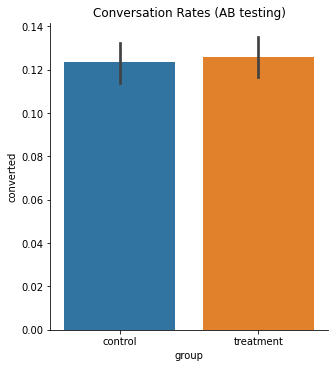

In [230]:
# Let's plot our results:

g = sns.catplot(
    data=ab_test_df, x="group", y="converted", kind="bar", ci=95, aspect=0.95
)
plt.title("Conversation Rates (AB testing)")
plt.show()

In [231]:
# By just looking at the catplot, it does not seem that there is any difference. Let's try
# to do it from a statistical point of view.

from statsmodels.stats.proportion import proportions_ztest, proportion_confint


def result_subgroups(df, group, target):

    results = df[df["group"] == group][target]
    count = results.count()

    success = results.sum()

    return results, count, success

In [232]:
control_res, n_control, success_control = result_subgroups(
    ab_test_df, "control", "converted"
)
treat_res, n_treat, success_treat = result_subgroups(
    ab_test_df, "treatment", "converted"
)

# Let's stack results for using them in the Z testing now.
success = [success_control, success_treat]
nobs = [n_control, n_treat]

# I can derive z stat, p value and CI
z_stat, pval = proportions_ztest(success, nobs)

(lower_control, upper_control), (lower_treat, upper_treat) = proportion_confint(
    success, nobs, alpha=0.05
)

In [233]:
print(f"Z statistic value:  {z_stat:.5f}")
print(f"P_value:  {pval:.5f}")


if pval < 0.05:
    print("Reject the null")
else:
    print("We fail to reject the null")


print(f"95% CI for control:    {lower_control:.5f}, {upper_control:.5f} ")
print(f"95% CI for treatment:  {lower_treat:.5f}, {upper_treat:.5f}")

Z statistic value:  -0.34296
P_value:  0.73163
We fail to reject the null
95% CI for control:    0.11393, 0.11618 
95% CI for treatment:  0.13268, 0.13509


In [238]:
# Drawing conclusions
print("Our new design performes poorly")

#End

Our new design performes poorly
